# Topic Modelling Algorithms Experiment

## Overview

Topic modelling algorithms are a class of machine learning algorithms which largely grew out of natural language processing.
They are used to extract latent features, or topics, from a dataset using a variety of techniques.
In information retrieval for example, the topics latent to a query can be extracted by a well-trained model by analysing the terms used.
The documents most heavily associated with these topics are returned to the user, hopefully satisfying the user's request.

The mathematical techniques used can be generalised to more abstract datasets, with topics that may not be easily conceptualised by humans.
The [Amazon SageMaker object2vec](https://docs.aws.amazon.com/sagemaker/latest/dg/object2vec.html) algorithm uses neural embedding to represent objects in a low-dimensional space.
The algorithm accepts a diverse range of inputs where pairs can have some notion of similarity.
This can be applied to the classic NLP problem of sentence similarity, or to pairs of objects such as users and movies where similarity corresponds to a user's rating.

This experiment demonstrates the training and validation of the SageMaker object2vec algorithm, as well as several
prediction algorithms from the [Surprise Python scikit](http://surpriselib.com/) for use in recommender systems.
The algorithms report their internal validation metrics during training, which are then verified with additional test data.
The resulting metrics are compiled and reported using the Amazon SageMaker Experiments framework.

## Dataset

The dataset used in this experiment is the
[MovieLens 100k](https://grouplens.org/datasets/movielens/100k/) dataset.
It consists of 100,000 ratings from 943 users on 1682 movies.
The dataset provides some extra information about both the users and movies,
but for the task at hand all that is needed is user and movie ID pairings, along with their associated rating (1-5).

### [License](https://files.grouplens.org/datasets/movielens/ml-100k-README.txt)
```
The data set may be used for any research purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.
     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).
     * The user may not redistribute the data without separate
       permission.
     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a faculty member of the GroupLens Research Project at the
       University of Minnesota.
```

### Load Data

In [ ]:
%%bash

curl -o ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
unzip ml-100k.zip
rm ml-100k.zip

The ml-100k dataset comes with premade splits of the data for a variety of use cases.  
In this instance the breakdown is as follows:
- `ua.base` and `ua.test` are used for training and validation respectively, between them they hold all 100,000 ratings
- `ua.test` contains 9430 of the total 100,000 ratings, a 9.43% split with exactly 10 ratings per user
- `ub.test` is used for conducting our own testing, it too has 9430 ratings, none of which appear in `ua.test`

Shown is some basic exploratory data analysis to provide an idea of the dataset's characteristics.

In [1]:
import pandas as pd
import os

prefix = 'ml-100k'
dfs = []

for f in ['ua.base', 'ua.test', 'ub.test']:
    dfs.append(pd.read_csv(os.path.join(prefix, f), sep='\t', header=None))

[df_train, df_valid, df_test] = dfs

for (name, df) in zip(['Train', 'Validation', 'Test'], dfs):
    print(f"{name} dataset shape: {df.shape}")

df_train.head()

Train dataset shape: (90570, 4)
Validation dataset shape: (9430, 4)
Test dataset shape: (9430, 4)


,0,1,2,3
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


Note the last column (here automatically labelled 3), a Unix timestamp which will be dropped for the purposes of this experiment.

In [2]:
for df in dfs:
    df.drop(columns=[3], inplace=True)
    df.rename(columns={0:'userID', 1:'movieID', 2:'rating'}, inplace=True)

df_train.head()

,userID,movieID,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [3]:
df_total = df_train.append(df_valid)

print(f"Number of unique users: {df_total['userID'].nunique()}")
print(f"Number of unique movies: {df_total['movieID'].nunique()}")
print(f"Total number of ratings: {len(df_total)}")

Number of unique users: 943
Number of unique movies: 1682
Total number of ratings: 100000


Ratings per user:
	Min: user 926 with 20 ratings
	Max: user 405 with 737 ratings
	Median: 65 ratings


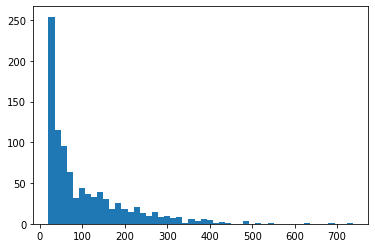

Ratings per movie:
	Min: movie 1653 with 1 ratings
	Max: movie 50 with 583 ratings
	Median: 27 ratings


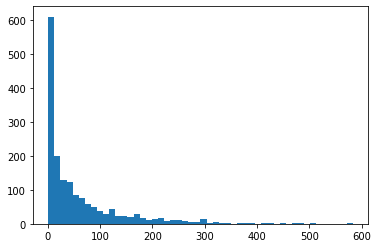

In [4]:
# calculate min, max, median ratings per user and ratings per movie
from collections import Counter
import matplotlib.pyplot as plt

for col in ['userID', 'movieID']:
    counts = Counter(df_total[col]).most_common()
    colMax = counts[0]
    colMin = counts[-1]
    colMed = counts[int(len(counts)/2)]

    name = col[:-2] # column name without "ID"
    print(f"Ratings per {name}:")
    print(f"\tMin: {name} {colMin[0]} with {colMin[1]} ratings")
    print(f"\tMax: {name} {colMax[0]} with {colMax[1]} ratings")
    print(f"\tMedian: {colMed[1]} ratings")
    
    num_ratings = [n for (_,n) in counts]
    plt.hist(num_ratings, bins=50)
    plt.show()

Finally, we confirm that `ua.base`(training set) and `ua.test`(validation set) are disjoint,
as well as `ua.test` and `ub.test`(testing set)

In [16]:
def checkForDuplicates(df_a, df_b):
    df_concat = df_a.append(df_b)
    # confirm that no user movie pair occurs more than once
    duplicates = df_concat.duplicated(['userID', 'movieID'])
    if duplicates.any():
        [uID, mID] = df_concat.loc[duplicates][['userID', 'movieID']].values[0]
        print(f"Duplicate found! userID: {uID}, movieID: {mID}.")
    else:
        print("No duplicates found, datasets are disjoint.")

print("Checking training set and validation set...")
checkForDuplicates(df_train, df_valid)
print("\nChecking validation set and testing set...")
checkForDuplicates(df_valid, df_test)

Checking training set and validation set...
No duplicates found, datasets are disjoint.

Checking validation set and testing set...
No duplicates found, datasets are disjoint.


### Data Preparation
The algorithms to be trained have different requirements for the format of the input data.
The SageMaker object2vec algorithm requires [JSON Lines](https://docs.aws.amazon.com/sagemaker/latest/dg/object2vec-training-formats.html),
while the Surprise scikit algorithms expect [CSV input](https://surprise.readthedocs.io/en/stable/reader.html).  
To accomodate this, the dataset will be replicated in both formats and uploaded to S3.
While the format of the data is different, the value of the information remains exactly the same. 

In [4]:
import boto3
import io

s3_client = boto3.client('s3')
bucket = "sagemaker-movielens-experiment"

In [58]:
# upload CSV data
for (channel, df) in zip(['train', 'validation', 'test'], dfs):
    # use tab separator as in ml-100k dataset
    data_str = df.to_csv(sep='\t', header=False, index=False)
    # upload_fileobj requires a file-like object
    data_bin = io.BytesIO(data_str.encode('utf-8'))
    s3_client.upload_fileobj(data_bin, bucket, f'input/csv/{channel}/{channel}.csv')

# upload JSON Lines data
for (channel, df) in zip(['train', 'validation', 'test'], dfs):
    # each line should be formatted as {"in0":[userID],"in1":[movieID],"label":rating}
    # rename columns
    df_tmp = df.rename(columns={'userID':'in0','movieID':'in1','rating':'label'})
    # transform "in0" and "in1" into columns of singleton lists
    df_tmp[['in0','in1']] = df_tmp[['in0', 'in1']].transform(lambda c: [[x] for x in c])
    # write to json and upload
    data_str = df_tmp.to_json(orient='records', lines=True)
    # upload_fileobj requires a file-like object
    data_bin = io.BytesIO(data_str.encode('utf-8'))
    s3_client.upload_fileobj(data_bin, bucket, f"input/jsonl/{channel}/{channel}.jsonl")

## Training

Each algorithm is now trained on the preprocessed datasets.
Information such as hyperparameter values, input data configuration and training metrics are stored by Amazon for each training job.  
We can query our training jobs based on these values, as well as the user-defined tags which are used to track the experiment.

In [1]:
import sagemaker
from sagemaker import get_execution_role

# create session to manage API calls
smclient = boto3.client(service_name='sagemaker')
sess = sagemaker.Session(sagemaker_client=smclient)
# get sagemaker execution role for training
role = get_execution_role()

# define experiment tags to track
tagKey = "Experiment"
tagVal = "FYPDemo"

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210309T220811 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


### Object2Vec

In [2]:
# get the algorithm image
from sagemaker.image_uris import retrieve

container = retrieve('object2vec', boto3.Session().region_name)

In [5]:
# create input data paths
from sagemaker.inputs import TrainingInput

base_path = f"s3://{bucket}/input/jsonl/"
input_paths = {}
for channel in ['train', 'validation']:
    input_paths[channel] = TrainingInput(base_path + f"{channel}/{channel}.jsonl",
                                         distribution="ShardedByS3Key",
                                         content_type="application/jsonlines")

# create ouput path for generated model artifacts
output_path = f"s3://{bucket}/output/object2vec/"

In [6]:
# define hyperparameters
hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 1024,
    "epochs": 20,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error",
}

In [7]:
# begin training
regressor = sagemaker.estimator.Estimator(container,
                                         role,
                                         instance_count=1,
                                         instance_type='ml.p2.xlarge',
                                         output_path=output_path + "output-1",
                                         tags=[{"Key": tagKey,"Value": tagVal}],
                                         sagemaker_session=sess)

regressor.set_hyperparameters(**hyperparameters)

regressor.fit(input_paths)

2021-04-29 05:02:38 Starting - Starting the training job...
2021-04-29 05:02:40 Starting - Launching requested ML instancesProfilerReport-1619672558: InProgress
......
2021-04-29 05:04:06 Starting - Preparing the instances for training............
2021-04-29 05:06:06 Downloading - Downloading input data
2021-04-29 05:06:06 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script

2021-04-29 05:07:06 Training - Training image download completed. Training in progress.[04/29/2021 05:06:57 INFO 140016395286336] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'enc_dim': 4096, 'mlp_dim': 512, 'mlp_activation': 'linear', 'mlp_layers': 2, 'output_layer': 'softmax', 'optimizer': 'adam', 'learning_rate': 0.0004, 'mini_batch_size': 32, 'epochs': 30, 'bucket_width': 0, 'early_stopping_tolerance': 0.01, 'early_stopping_patience': 3, 'dropout': 0, 'weight_d

In [17]:
# alter hyperparameter and repeat training
hyperparameters['enc0_network'] = "bilstm"

regressor = sagemaker.estimator.Estimator(container,
                                         role,
                                         instance_count=1,
                                         instance_type='ml.p2.xlarge',
                                         output_path=output_path + "output-2",
                                         tags=[{"Key": tagKey,"Value": tagVal}],
                                         sagemaker_session=sess)

regressor.set_hyperparameters(**hyperparameters)

regressor.fit(input_paths)

2021-04-28 17:23:58 Starting - Starting the training job...
2021-04-28 17:24:22 Starting - Launching requested ML instancesProfilerReport-1619630638: InProgress
......
2021-04-28 17:25:22 Starting - Preparing the instances for training.........
2021-04-28 17:26:43 Downloading - Downloading input data
2021-04-28 17:26:43 Training - Downloading the training image......
2021-04-28 17:27:45 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/28/2021 17:27:49 INFO 140508977309504] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'enc_dim': 4096, 'mlp_dim': 512, 'mlp_activation': 'linear', 'mlp_layers': 2, 'output_layer': 'softmax', 'optimizer': 'adam', 'learning_rate': 0.0004, 'mini_batch_size': 32, 'epochs': 30, 'bucket_width': 0, 'early_stopping_tolerance': 0.01, 'early_stopping_patience': 3, 'dropout': 0, 'weight_dec

In [43]:
# alter hyperparameter and repeat training
hyperparameters['enc0_network'] = "hcnn"

regressor = sagemaker.estimator.Estimator(container,
                                         role,
                                         instance_count=1,
                                         instance_type='ml.p2.xlarge',
                                         output_path=output_path + "output-3",
                                         tags=[{"Key": tagKey,"Value": tagVal}],
                                         sagemaker_session=sess)

regressor.set_hyperparameters(**hyperparameters)

regressor.fit(input_paths)

2021-04-28 19:18:46 Starting - Starting the training job...
2021-04-28 19:19:09 Starting - Launching requested ML instancesProfilerReport-1619637526: InProgress
......
2021-04-28 19:20:10 Starting - Preparing the instances for training.........
2021-04-28 19:21:37 Downloading - Downloading input data...
2021-04-28 19:22:10 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/28/2021 19:23:00 INFO 139782663567168] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'enc_dim': 4096, 'mlp_dim': 512, 'mlp_activation': 'linear', 'mlp_layers': 2, 'output_layer': 'softmax', 'optimizer': 'adam', 'learning_rate': 0.0004, 'mini_batch_size': 32, 'epochs': 30, 'bucket_width': 0, 'early_stopping_tolerance': 0.01, 'early_stopping_patience': 3, 'dropout': 0, 'weight_decay': 0, 'negative_sampling_rate': 0, 'comparator_list': 'hadamard, concat, abs_diff', 

### Surprise

#### SVD

In [66]:
# get the algorithm image
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
container = f"{account}.dkr.ecr.{region}.amazonaws.com/sagemaker-surprise-svd:latest"

In [67]:
# create input data paths
from sagemaker.inputs import TrainingInput

base_path = f"s3://{bucket}/input/csv/"
input_paths = {}
for channel in ['train', 'validation']:
    input_paths[channel] = TrainingInput(base_path + f"{channel}/{channel}.csv",
                                         distribution="ShardedByS3Key",
                                         content_type="text/csv")

# create ouput path for generated model artifacts
output_path = f"s3://{bucket}/output/surprise-svd/"

In [69]:
# begin training
svd = sagemaker.estimator.Estimator(container,
                                   role,
                                   instance_count=1,
                                   instance_type='ml.c4.2xlarge',
                                   output_path=output_path,
                                   tags=[{"Key": tagKey,"Value": tagVal}],
                                   sagemaker_session=sess,
                                   metric_definitions=[{'Name': 'validation:mean_squared_error', 'Regex': 'MetricRMSE=(.*?);'}])

svd.fit(input_paths)

2021-04-28 19:52:10 Starting - Starting the training job...
2021-04-28 19:52:33 Starting - Launching requested ML instancesProfilerReport-1619639530: InProgress
......
2021-04-28 19:53:33 Starting - Preparing the instances for training......
2021-04-28 19:54:34 Downloading - Downloading input data
2021-04-28 19:54:34 Training - Downloading the training image...
2021-04-28 19:55:11 Uploading - Uploading generated training modelStarting the training.
MetricRMSE=0.9501996976986254;
Training complete.

2021-04-28 19:55:34 Completed - Training job completed
Training seconds: 60
Billable seconds: 60


#### SVD++

In [123]:
# get the algorithm image
container = f"{account}.dkr.ecr.{region}.amazonaws.com/sagemaker-surprise-svdpp:latest"
# create ouput path for generated model artifacts
output_path = f"s3://{bucket}/output/surprise-svdpp/"

# begin training
svdpp = sagemaker.estimator.Estimator(container,
                                      role,
                                      instance_count=1,
                                      instance_type='ml.c4.2xlarge',
                                      output_path=output_path,
                                      tags=[{"Key": tagKey,"Value": tagVal}],
                                      sagemaker_session=sess,
                                      metric_definitions=[{'Name': 'validation:mean_squared_error', 'Regex': 'MetricRMSE=(.*?);'}])

svdpp.fit(input_paths)

2021-04-28 21:42:07 Starting - Starting the training job...
2021-04-28 21:42:30 Starting - Launching requested ML instancesProfilerReport-1619646127: InProgress
......
2021-04-28 21:43:34 Starting - Preparing the instances for training......
2021-04-28 21:44:38 Downloading - Downloading input data
2021-04-28 21:44:38 Training - Downloading the training image.....Starting the training.

2021-04-28 21:45:31 Training - Training image download completed. Training in progress.MetricRMSE=0.9369658404487412;
Training complete.

2021-04-28 21:49:00 Uploading - Uploading generated training model
2021-04-28 21:49:00 Completed - Training job completed
Training seconds: 274
Billable seconds: 274


#### NMF

In [151]:
# get the algorithm image
container = f"{account}.dkr.ecr.{region}.amazonaws.com/sagemaker-surprise-nmf:latest"
# create ouput path for generated model artifacts
output_path = f"s3://{bucket}/output/surprise-nmf/"

# begin training
nmf = sagemaker.estimator.Estimator(container,
                                      role,
                                      instance_count=1,
                                      instance_type='ml.c4.2xlarge',
                                      output_path=output_path,
                                      tags=[{"Key": tagKey,"Value": tagVal}],
                                      sagemaker_session=sess,
                                      metric_definitions=[{'Name': 'validation:mean_squared_error', 'Regex': 'MetricRMSE=(.*?);'}])

nmf.fit(input_paths)

2021-04-28 22:16:28 Starting - Starting the training job...
2021-04-28 22:16:51 Starting - Launching requested ML instancesProfilerReport-1619648188: InProgress
......
2021-04-28 22:17:51 Starting - Preparing the instances for training...
2021-04-28 22:18:25 Downloading - Downloading input data...
2021-04-28 22:18:51 Training - Downloading the training image..Starting the training.
MetricRMSE=0.9928632845948795;
Training complete.

2021-04-28 22:19:18 Uploading - Uploading generated training model
2021-04-28 22:19:18 Completed - Training job completed
Training seconds: 53
Billable seconds: 53


#### KNNBasic

In [133]:
# get the algorithm image
container = f"{account}.dkr.ecr.{region}.amazonaws.com/sagemaker-surprise-knnbasic:latest"
# create ouput path for generated model artifacts
output_path = f"s3://{bucket}/output/surprise-knnbasic/"

# begin training
knnbasic = sagemaker.estimator.Estimator(container,
                                      role,
                                      instance_count=1,
                                      instance_type='ml.c4.2xlarge',
                                      output_path=output_path,
                                      tags=[{"Key": tagKey,"Value": tagVal}],
                                      sagemaker_session=sess,
                                      metric_definitions=[{'Name': 'validation:mean_squared_error', 'Regex': 'MetricRMSE=(.*?);'}])

knnbasic.fit(input_paths)

2021-04-28 22:07:19 Starting - Starting the training job...
2021-04-28 22:07:41 Starting - Launching requested ML instancesProfilerReport-1619647638: InProgress
.........
2021-04-28 22:09:10 Starting - Preparing the instances for training......
2021-04-28 22:10:12 Downloading - Downloading input data
2021-04-28 22:10:12 Training - Downloading the training image...
2021-04-28 22:10:46 Uploading - Uploading generated training modelStarting the training.
Computing the msd similarity matrix...
Done computing similarity matrix.
MetricRMSE=0.9963111213563114;
Training complete.

2021-04-28 22:11:02 Completed - Training job completed
Training seconds: 53
Billable seconds: 53


#### KNNWithMeans

In [168]:
# get the algorithm image
container = f"{account}.dkr.ecr.{region}.amazonaws.com/sagemaker-surprise-knnmeans:latest"
# create ouput path for generated model artifacts
output_path = f"s3://{bucket}/output/surprise-knnmeans/"

# begin training
knnmeans = sagemaker.estimator.Estimator(container,
                                      role,
                                      instance_count=1,
                                      instance_type='ml.c4.2xlarge',
                                      output_path=output_path,
                                      tags=[{"Key": tagKey,"Value": tagVal}],
                                      sagemaker_session=sess,
                                      metric_definitions=[{'Name': 'validation:mean_squared_error', 'Regex': 'MetricRMSE=(.*?);'}])

knnmeans.fit(input_paths)

2021-04-28 22:39:29 Starting - Starting the training job...
2021-04-28 22:39:30 Starting - Launching requested ML instancesProfilerReport-1619649568: InProgress
......
2021-04-28 22:40:43 Starting - Preparing the instances for training......
2021-04-28 22:41:43 Downloading - Downloading input data
2021-04-28 22:41:43 Training - Downloading the training image...
2021-04-28 22:42:23 Uploading - Uploading generated training model
2021-04-28 22:42:23 Completed - Training job completed
Starting the training.
Computing the msd similarity matrix...
Done computing similarity matrix.
MetricRMSE=0.9715234551918015;
Training complete.
Training seconds: 53
Billable seconds: 53


#### SlopeOne

In [182]:
# get the algorithm image
container = f"{account}.dkr.ecr.{region}.amazonaws.com/sagemaker-surprise-slopeone:latest"
# create ouput path for generated model artifacts
output_path = f"s3://{bucket}/output/surprise-slopeone/"

# begin training
slopeone = sagemaker.estimator.Estimator(container,
                                      role,
                                      instance_count=1,
                                      instance_type='ml.c4.2xlarge',
                                      output_path=output_path,
                                      tags=[{"Key": tagKey,"Value": tagVal}],
                                      sagemaker_session=sess,
                                      metric_definitions=[{'Name': 'validation:mean_squared_error', 'Regex': 'MetricRMSE=(.*?);'}])

slopeone.fit(input_paths)

2021-04-28 22:47:38 Starting - Starting the training job...
2021-04-28 22:47:40 Starting - Launching requested ML instancesProfilerReport-1619650058: InProgress
......
2021-04-28 22:49:05 Starting - Preparing the instances for training...
2021-04-28 22:49:36 Downloading - Downloading input data...
2021-04-28 22:50:06 Training - Downloading the training image..Starting the training.
MetricRMSE=0.9648840238100149;
Training complete.

2021-04-28 22:50:26 Uploading - Uploading generated training model
2021-04-28 22:50:26 Completed - Training job completed
Training seconds: 47
Billable seconds: 47


## Metric Comparison

In [183]:
# construct query for training jobs from this experiment
search_params={
    "MaxResults": 10,
    "Resource": "TrainingJob",
    "SearchExpression": {
        "Filters": [
            {
                "Name": f"Tags.{tagKey}",
                "Operator": "Equals",
                "Value": tagVal
            },
            {
                "Name": "TrainingJobStatus",
                "Operator": "Equals",
                "Value": "Completed"
            }
        ]
    },
    "SortBy": "Metrics.validation:mean_squared_error",
    "SortOrder": "Ascending"
}

results = smclient.search(**search_params)
print(f"Search query returned {len(results['Results'])} training jobs")

Search query returned 9 training jobs


### Object2Vec Network Model Comparison

The object2vec algorithm offers three network models to choose from. These are HCNN,
a hierarchical convolutional neural network, biLSTM, a bidirectional long short-term
memory network, and pooled embedding, which averages the embedding of all tokens.
The validation metric of each network model can now be retrieved and plotted.
The best of these will be used in the overall algorithm comparison.

In [184]:
# extract training job metrics
job_metrics = []

for result in results['Results']:
    job = result['TrainingJob']
    name = job['TrainingJobName']
    if name.startswith('object2vec'):
        metrics = job['FinalMetricDataList']
        train_rmse = next(m for m in metrics if m['MetricName'] == 'train:mean_squared_error')['Value']
        validation_rmse = next(m for m in metrics if m['MetricName'] == 'validation:mean_squared_error')['Value']
        job_metrics.append((name, train_rmse, validation_rmse))

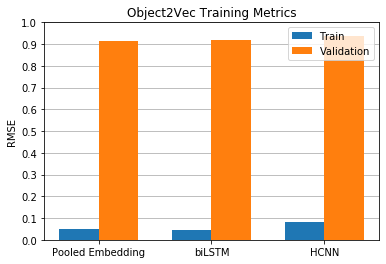

In [185]:
labels = ['Pooled Embedding', 'biLSTM', 'HCNN']
train_score = [train for (_, train, _) in job_metrics]
valid_score = [valid for (_, _, valid) in job_metrics]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
train_bars = ax.bar(x - width/2, train_score, width, label='Train')
valid_bars = ax.bar(x + width/2, valid_score, width, label='Validation')

ax.set_ylabel('RMSE')
ax.set_title('Object2Vec Training Metrics')
ax.set_xticks(x)
ax.set_yticks(np.linspace(0,1,11))
ax.set_xticklabels(labels)
ax.legend()
ax.set_axisbelow(True)
plt.grid(True, axis='y')

plt.show()

### Algorithm Comparison

In [186]:
# extract training job metrics
job_metrics = []

for result in results['Results']:
    job = result['TrainingJob']
    name = job['TrainingJobName']
    metrics = job['FinalMetricDataList']
    validation_rmse = next(m for m in metrics if m['MetricName'] == 'validation:mean_squared_error')['Value']
    job_metrics.append((name, validation_rmse))

In [187]:
job_metrics

[('object2vec-2021-04-28-17-23-58-543', 0.9133979678153992),
 ('object2vec-2021-04-28-17-18-11-479', 0.917380154132843),
 ('sagemaker-surprise-svdpp-2021-04-28-21-42-07-188', 0.936965823173523),
 ('object2vec-2021-04-28-19-18-46-639', 0.9377473592758179),
 ('sagemaker-surprise-svd-2021-04-28-19-52-10-601', 0.9501997232437134),
 ('sagemaker-surprise-slopeone-2021-04-28-22-47-38-614', 0.9648840427398682),
 ('sagemaker-surprise-knnmeans-2021-04-28-22-39-28-907', 0.9715234637260437),
 ('sagemaker-surprise-nmf-2021-04-28-22-16-28-386', 0.9928632974624634),
 ('sagemaker-surprise-knnbasic-2021-04-28-22-07-18-790', 0.9963111281394958)]

In [188]:
# select only the best performing model for each algorithm

# list of best models with metric (default None)
best_models = {'object2vec': None,
               'sagemaker-surprise-svd': None,
               'sagemaker-surprise-svdpp': None,
               'sagemaker-surprise-nmf': None,
               'sagemaker-surprise-knnbasic': None,
               'sagemaker-surprise-knnmeans': None,
               'sagemaker-surprise-slopeone': None
              }

# for each algorithm
for algo in best_models.keys():
    # for each model trained
    for (job_name, score) in job_metrics:
        # if this model uses that algorithm
        if job_name.startswith(algo+'-'):
            best_score = best_models[algo]
            # if this model has a better score than the current best
            if best_score == None or best_score >= score:
                # update best score
                best_models[algo] = score

In [191]:
# sort models by score
sorted_models = sorted(best_models.items(), key=lambda item: item[1])

# map algorithm names to chart labels
label_map = {
    'object2vec': 'object2vec',
    'sagemaker-surprise-svd': 'SVD',
    'sagemaker-surprise-svdpp': 'SVD++',
    'sagemaker-surprise-nmf': 'NMF',
    'sagemaker-surprise-knnbasic': 'KNNBasic',
    'sagemaker-surprise-knnmeans': 'KNNWithMeans',
    'sagemaker-surprise-slopeone': 'SlopeOne'
}

labeled_models = [(label_map[algo_name], score) for (algo_name, score) in sorted_models]

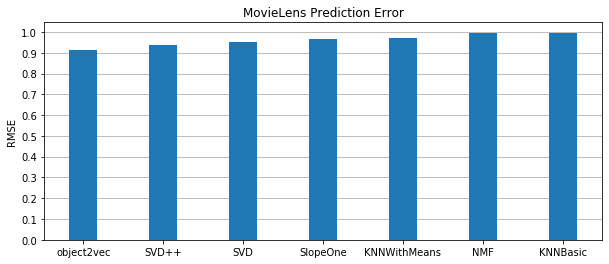

In [194]:
[labels, rmse_scores] = list(zip(*labeled_models))

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
fig.set_figwidth(10)
bars = ax.bar(x, rmse_scores, width)

ax.set_ylabel('RMSE')
ax.set_title('MovieLens Prediction Error')
ax.set_xticks(x)
ax.set_yticks(np.linspace(0,1,11))
ax.set_xticklabels(labels)
ax.set_axisbelow(True)
plt.grid(True, axis='y')

plt.show()

## Deploy Winning Model

The best performing model (here object2vec with pooled embedding) can now be deployed to an endpoint and used for inference.

In [8]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

regression_model = regressor.create_model()

In [9]:
predictor = regression_model.deploy(initial_instance_count=1,
                                    instance_type = 'ml.m4.xlarge',
                                    serializer = JSONSerializer(),
                                    deserializer = JSONDeserializer())

---------------!

We can test the endpoint by making a single test prediction.
(The actual rating for user 1 and movie 253 is 5)

In [10]:
# make a prediction
predictor.predict({"instances":[{"in0":[1],"in1":[253]}]})

{'predictions': [{'scores': [4.642399311065674]}]}

## Testing

We can now convert `df_test` to an inference payload and have the model make a prediction for each entry.

In [17]:
# make inference payload and get list of true ratings
payload = {"instances":[]}
true_ratings = []

for index, row in df_test.iterrows():
    userID = int(row['userID'])
    movieID = int(row['movieID'])
    rating = int(row['rating'])
    payload['instances'].append({"in0":[userID],"in1":[movieID]})
    true_ratings.append(rating)

In [18]:
# get predictions from predictor endpoint
predictions = predictor.predict(payload)

In [19]:
# extract list of predicted ratings
predicted_ratings = []
for pred in predictions['predictions']:
    predicted_ratings.append(pred['scores'][0])

r_predicted = np.array(predicted_ratings)
r_actual = np.array(true_ratings)

# calculate RMSE
error = r_predicted - r_actual
sqr_err = error ** 2
mse_err = sqr_err.sum()/len(sqr_err)
rmse_err = np.sqrt(mse_err)

In [20]:
rmse_err

0.27294449904556345

In [21]:
sess.delete_endpoint(predictor.endpoint_name)